# Basic CNN for traffic sign recognition
## Christian Igel, 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact me](mailto:igel@diku.dk) if you have suggestions for improving the notebook.

Do the imports first:

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

Check if a GPU is available:

In [10]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


The GTSRB data wrapped in a `Dataset`. This is implemented in the file `GTSRBTrafficSigns.py`. Let's import the class:

In [11]:
from GTSRBTrafficSigns import GTSRBTrafficSigns

In [12]:
dataset_train = GTSRBTrafficSigns()

Using existing ./GTSRB/train


Define the data loader for training:

In [13]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [14]:
print("Number of training patterns:", dataset_train.__len__())

Number of training patterns: 39209


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

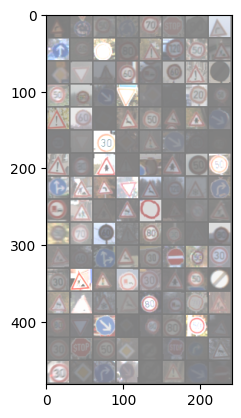

In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at each image in the batch with its label:

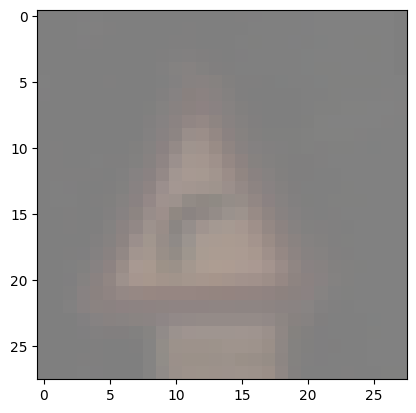

20 




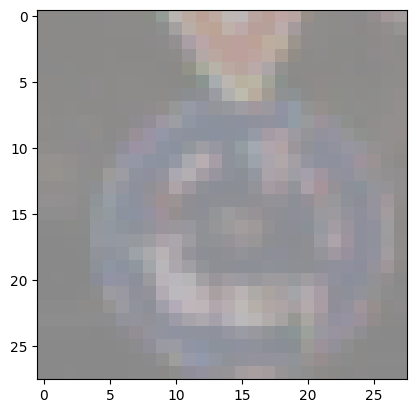

40 




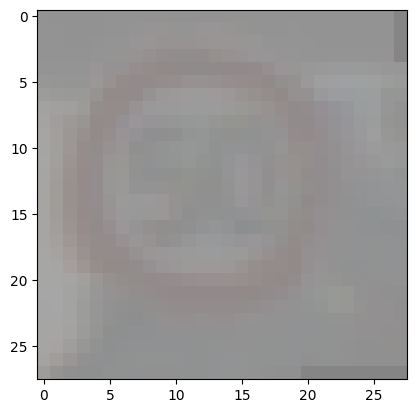

2 




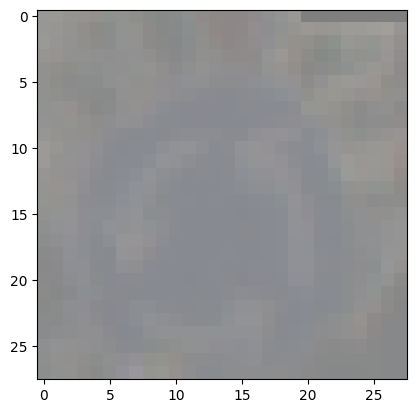

40 




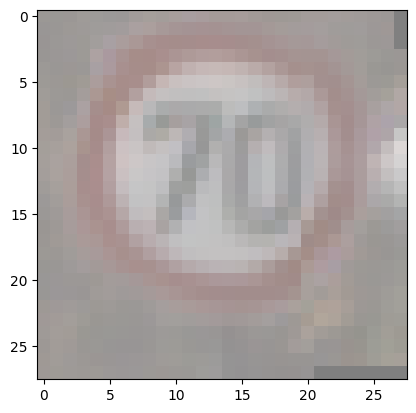

4 




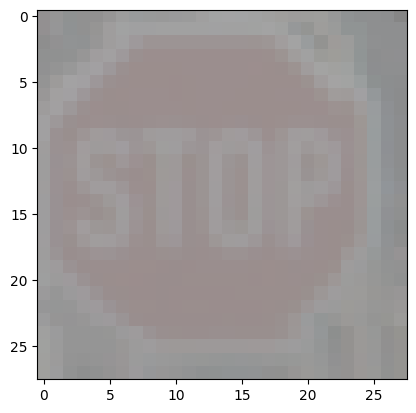

14 




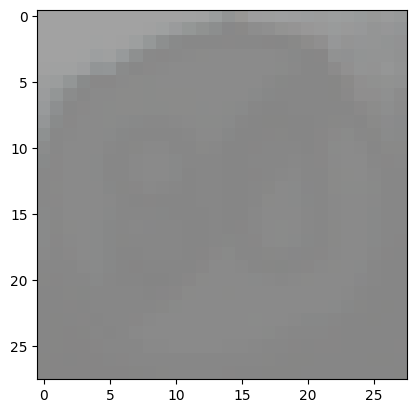

6 




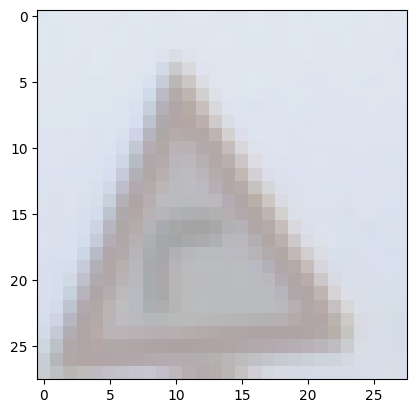

20 




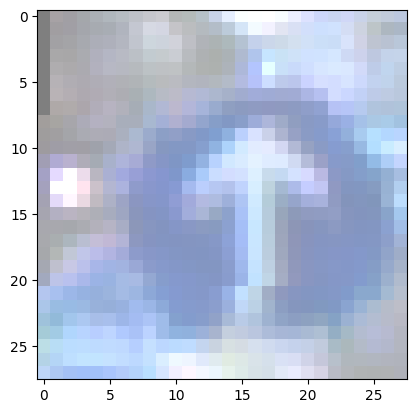

35 




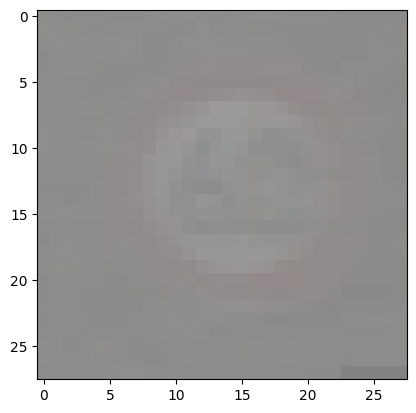

3 




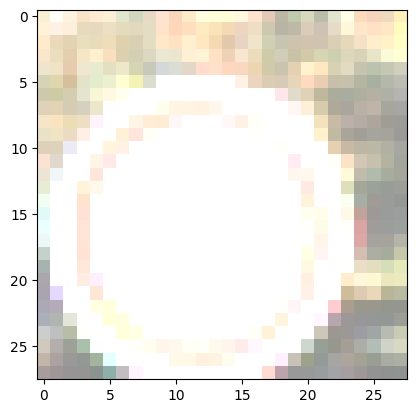

2 




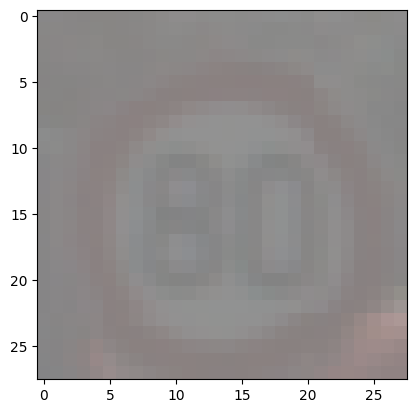

5 




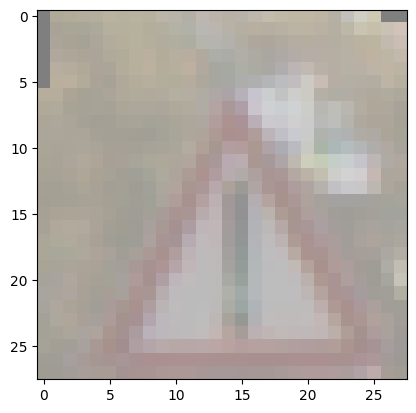

18 




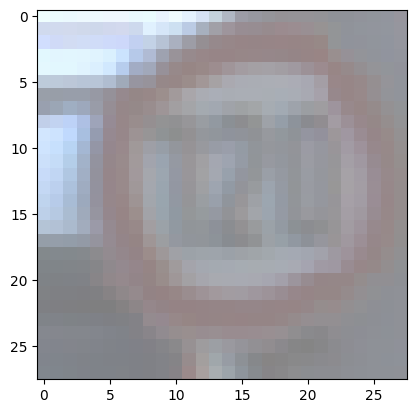

8 




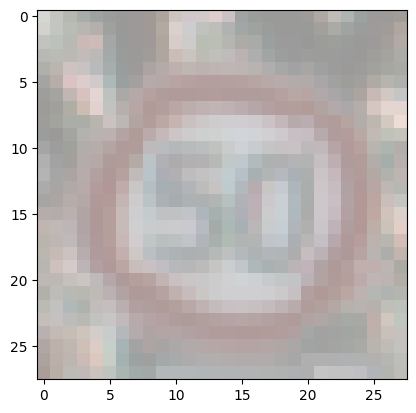

2 




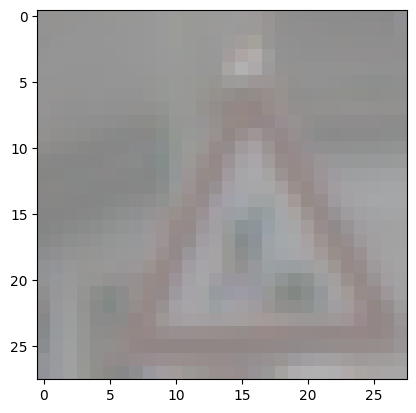

25 




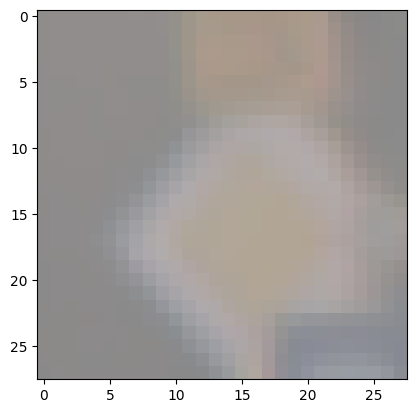

12 




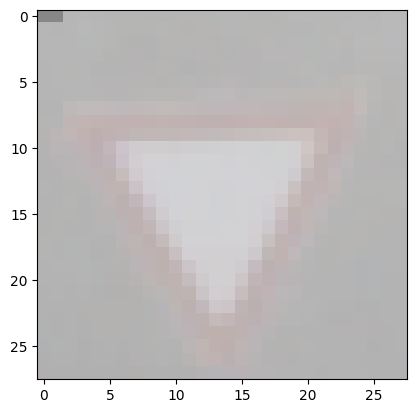

13 




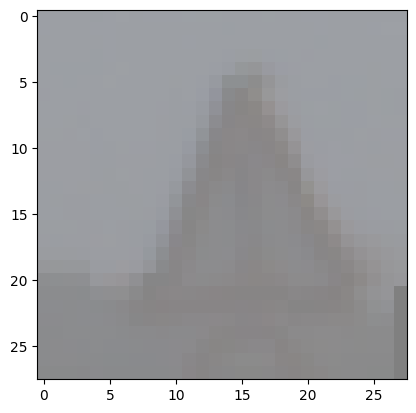

18 




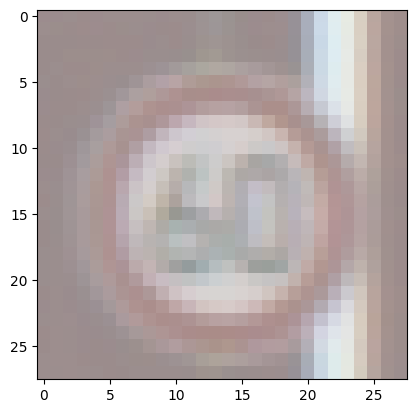

3 




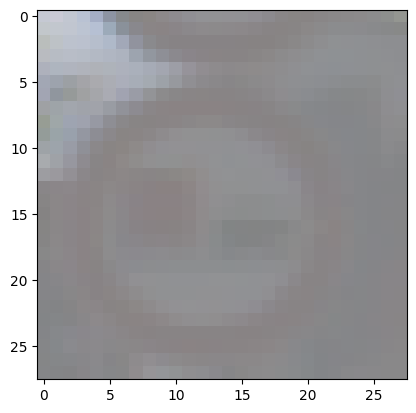

10 




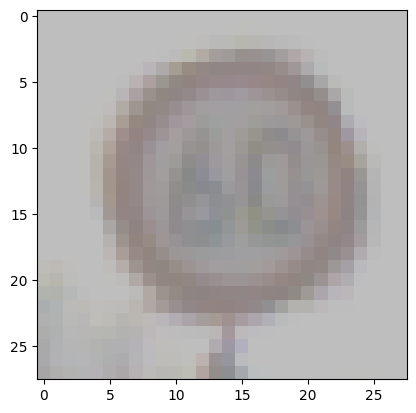

3 




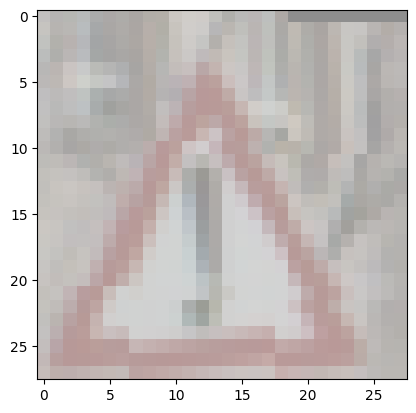

18 




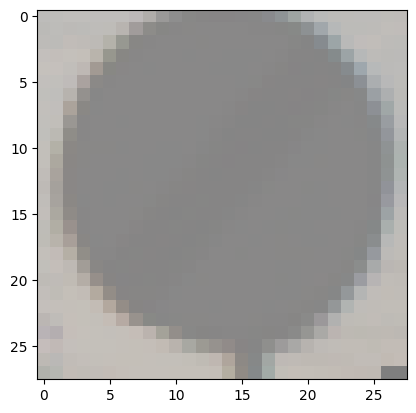

32 




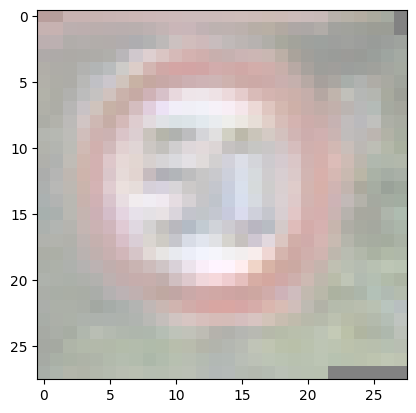

2 




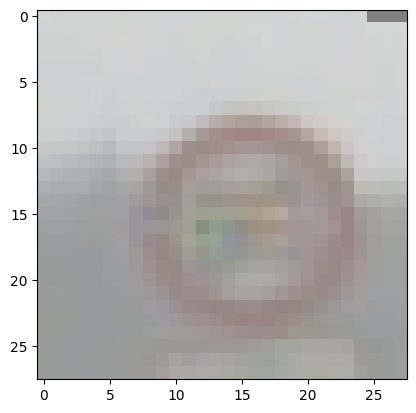

5 




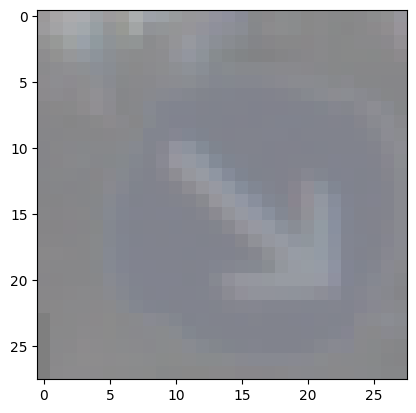

38 




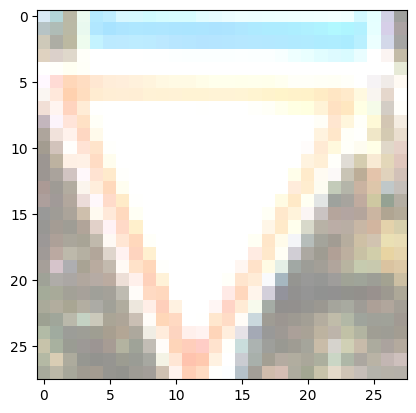

13 




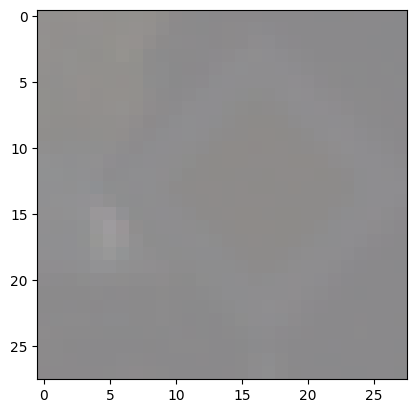

12 




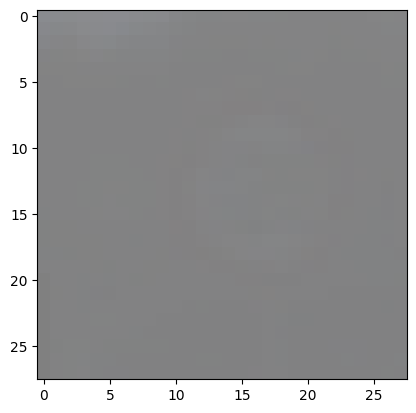

8 




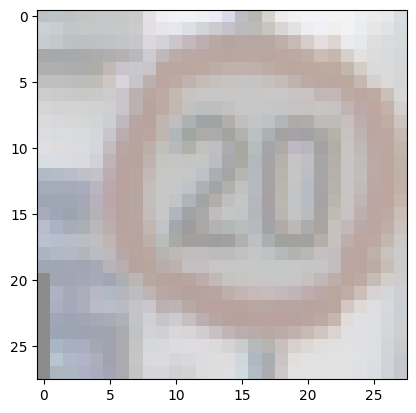

0 




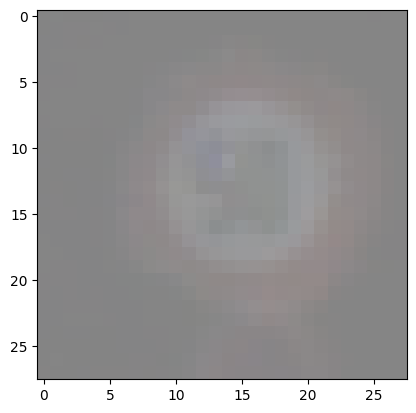

2 




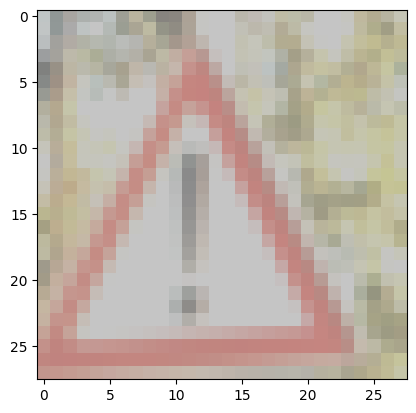

18 




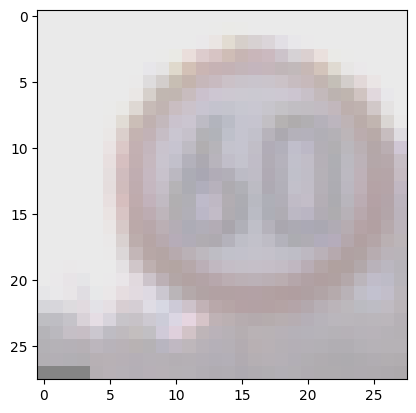

3 




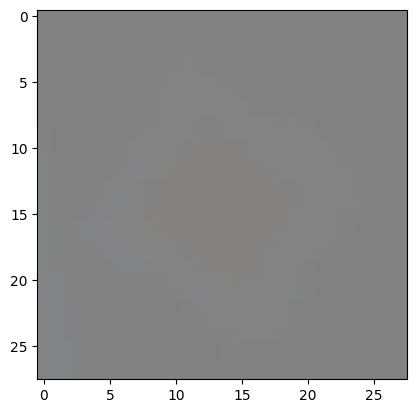

12 




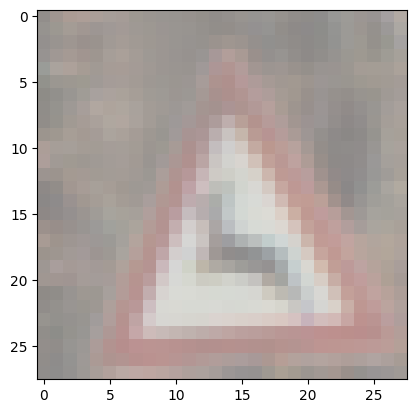

31 




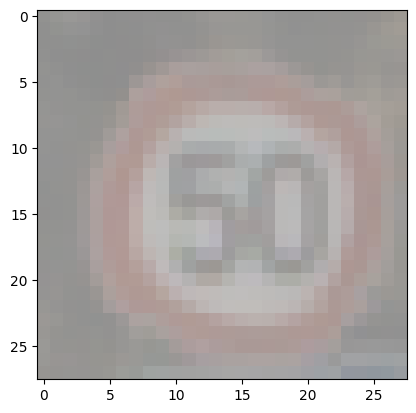

2 




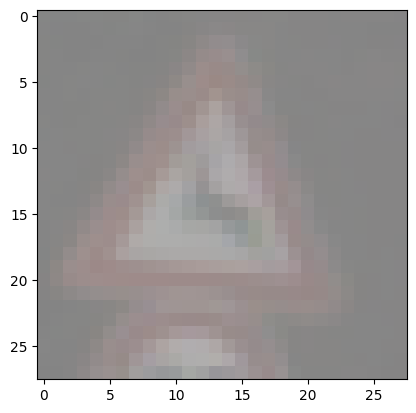

31 




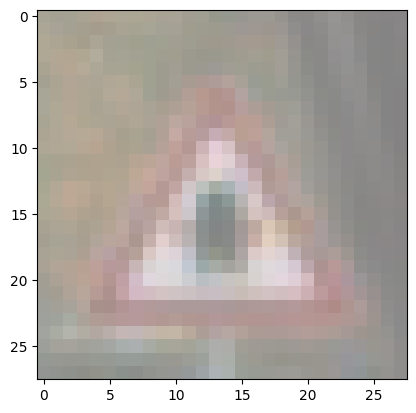

11 




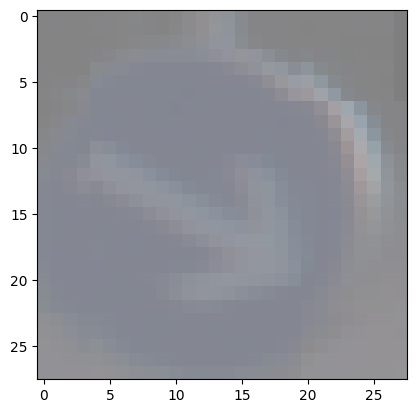

38 




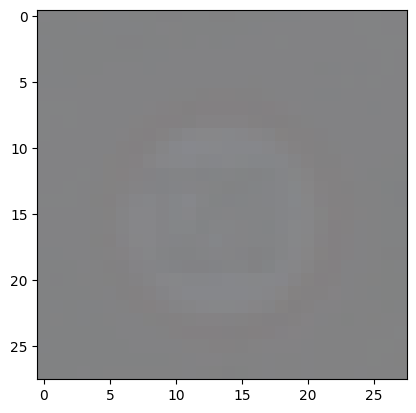

8 




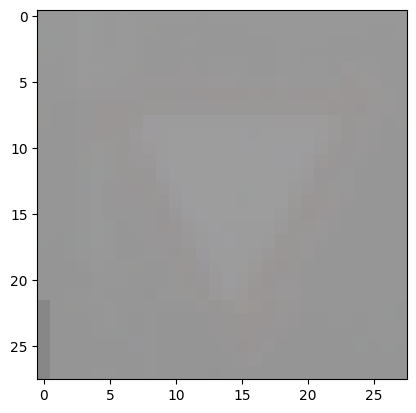

13 




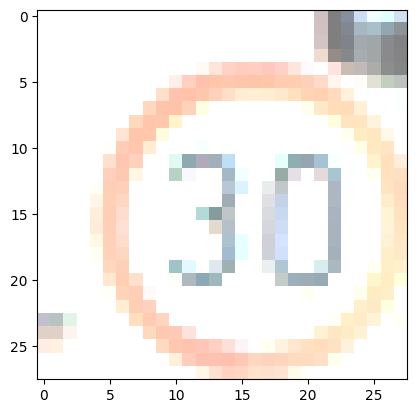

1 




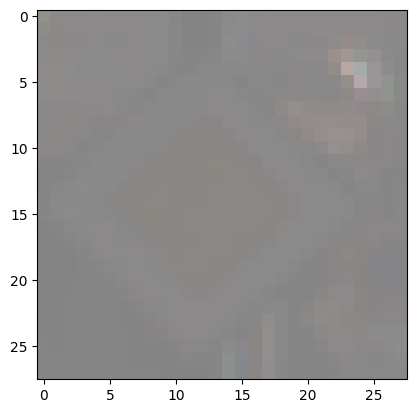

12 




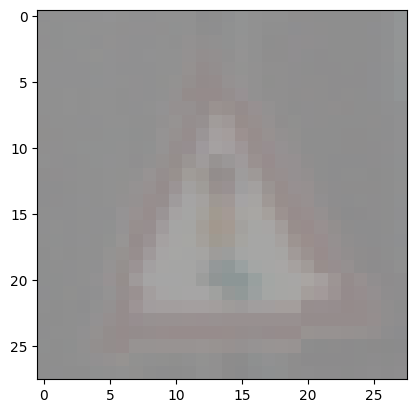

26 




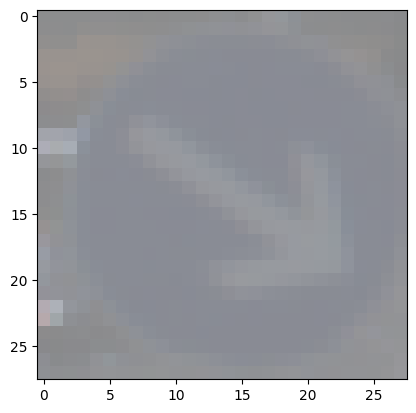

38 




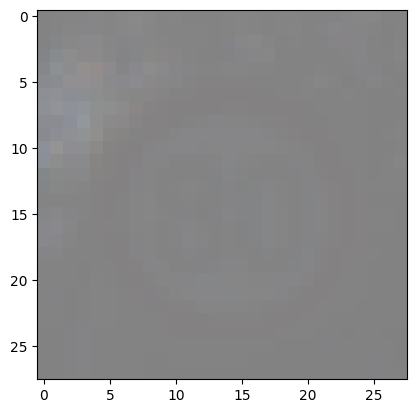

5 




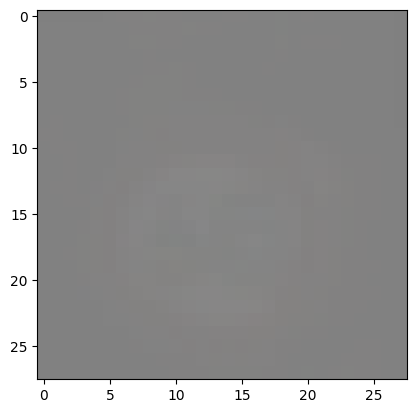

3 




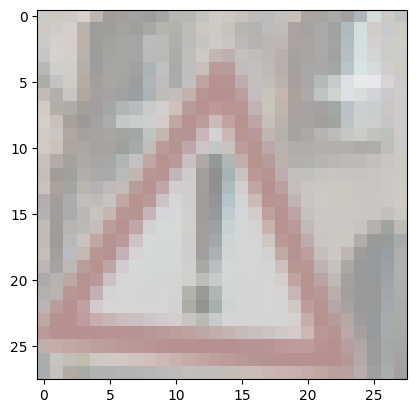

18 




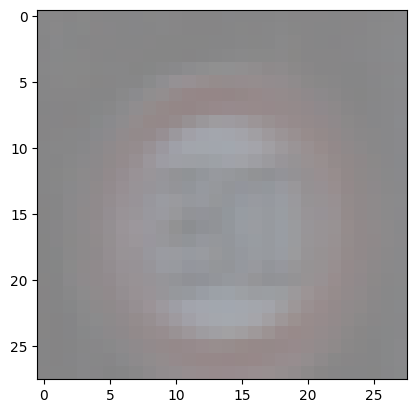

5 




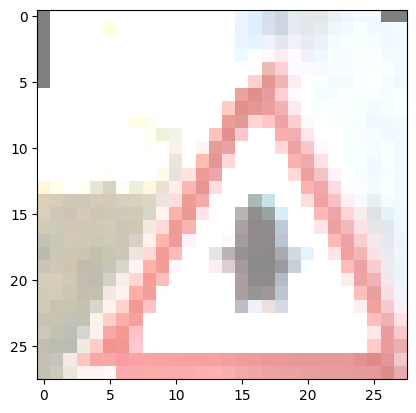

11 




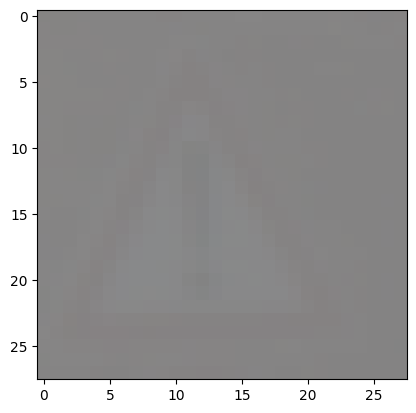

18 




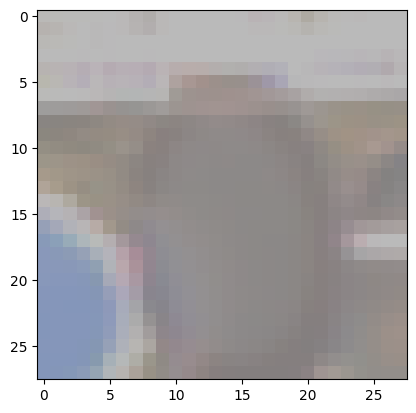

15 




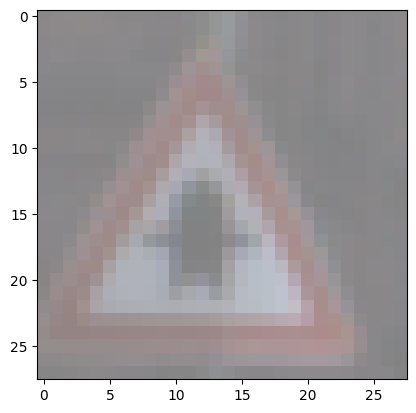

11 




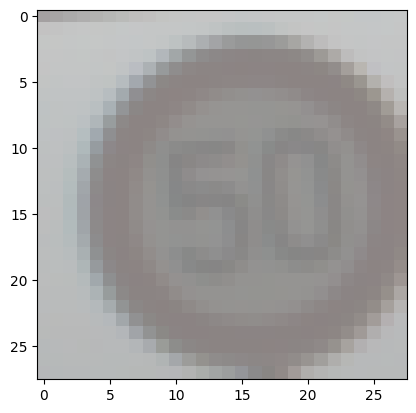

2 




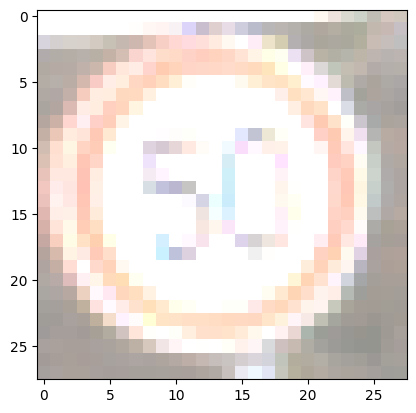

2 




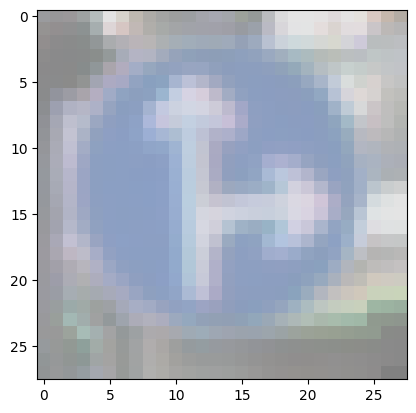

36 




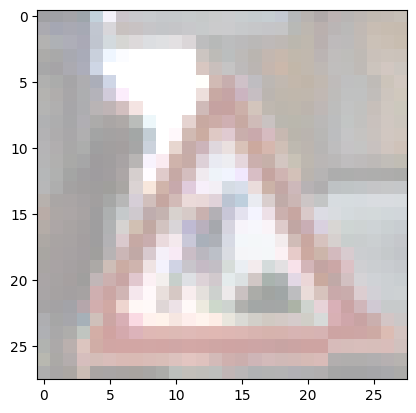

25 




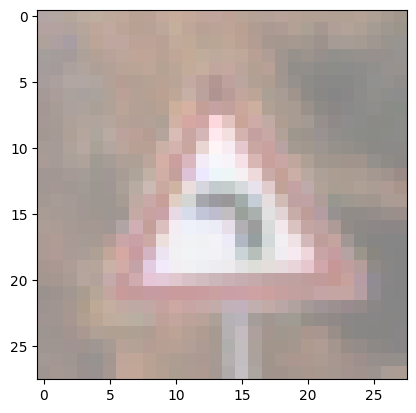

19 




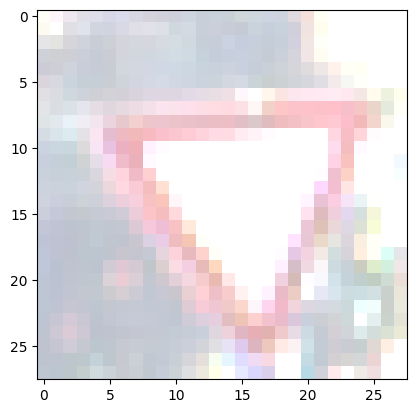

13 




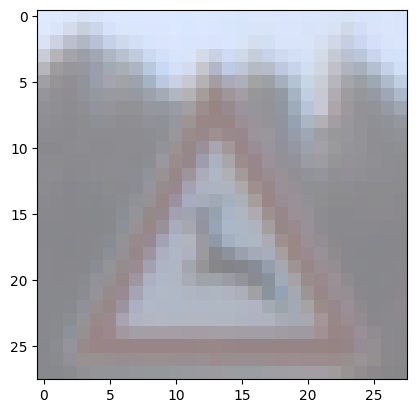

31 




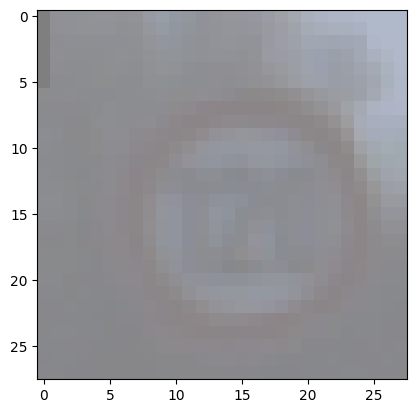

8 




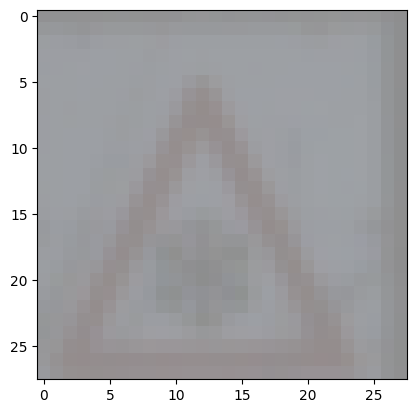

30 




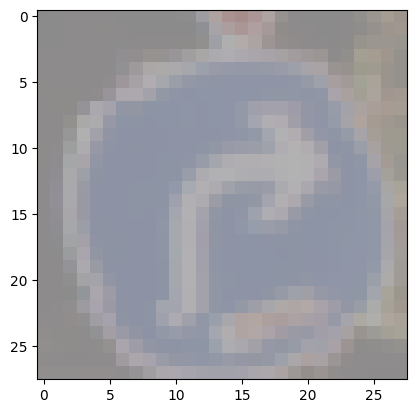

33 




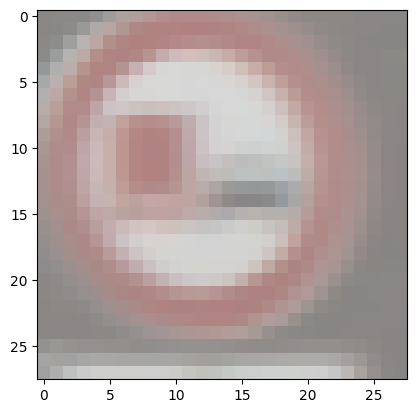

10 




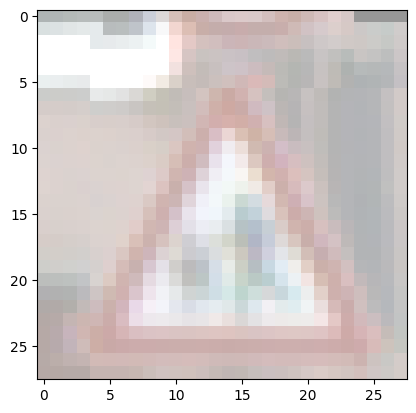

28 




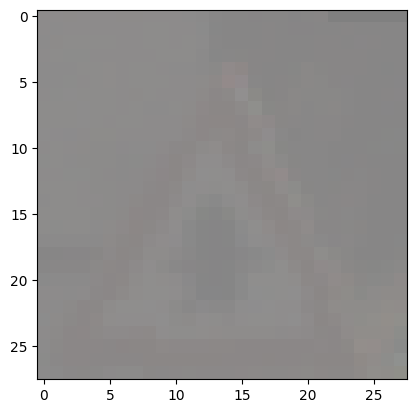

11 




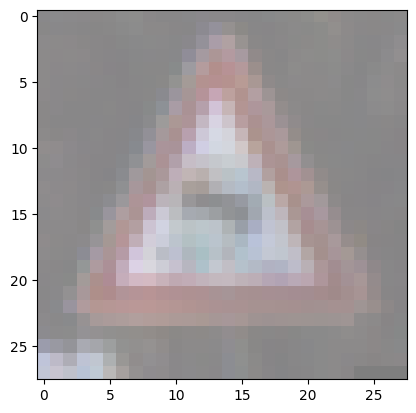

23 




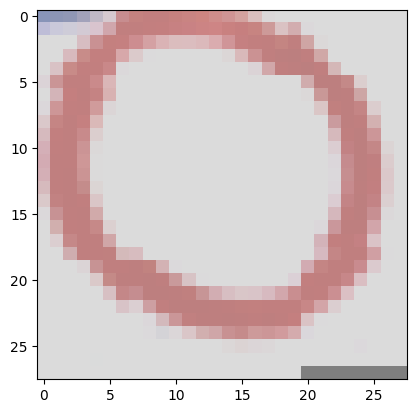

15 




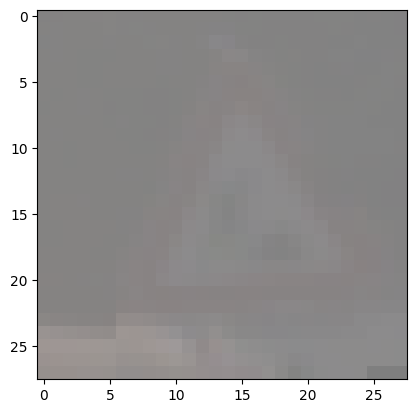

25 




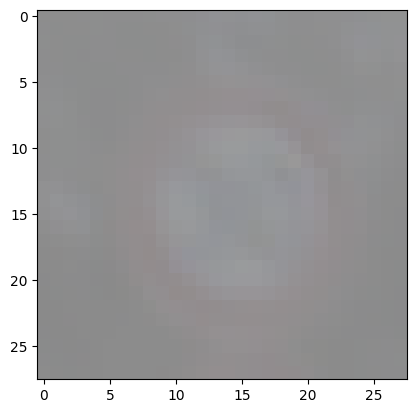

1 




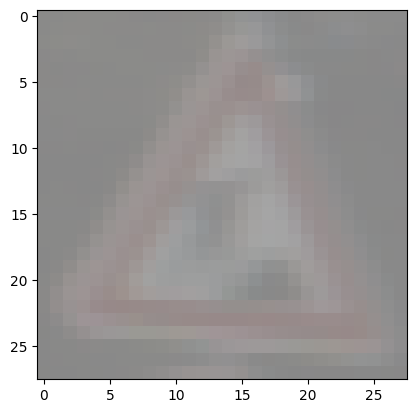

25 




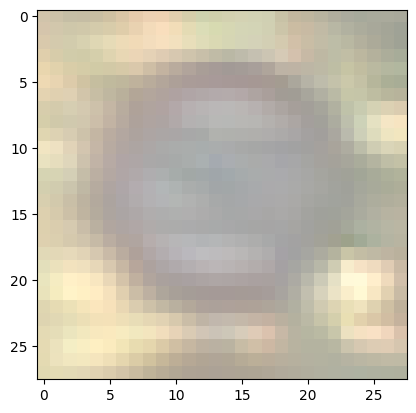

2 




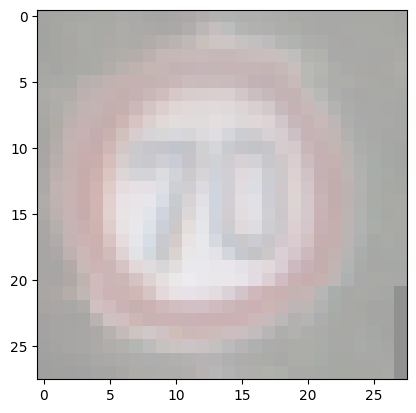

4 




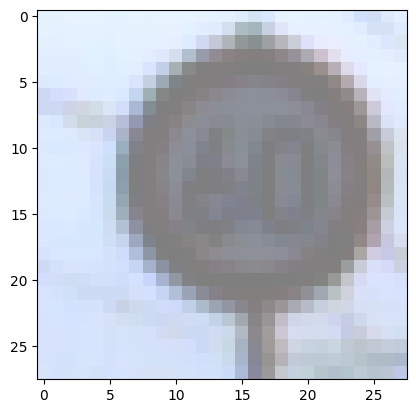

3 




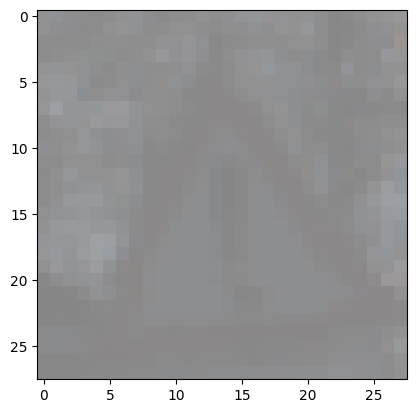

18 




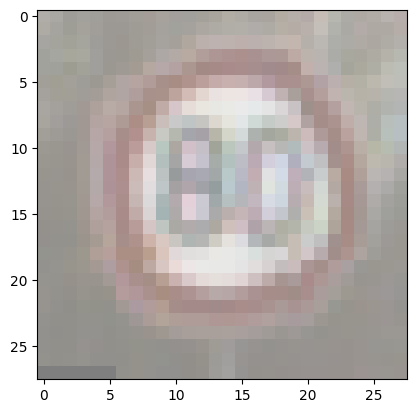

5 




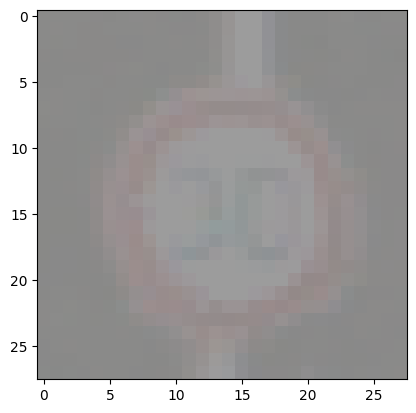

1 




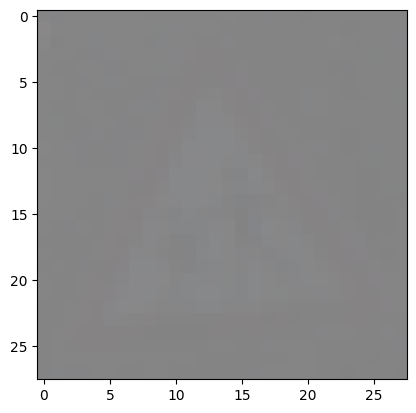

28 




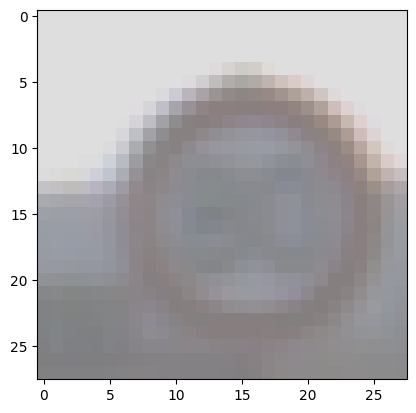

5 




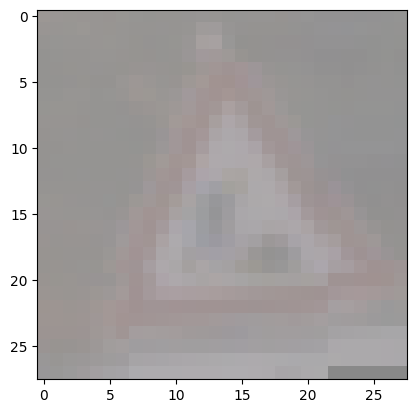

25 




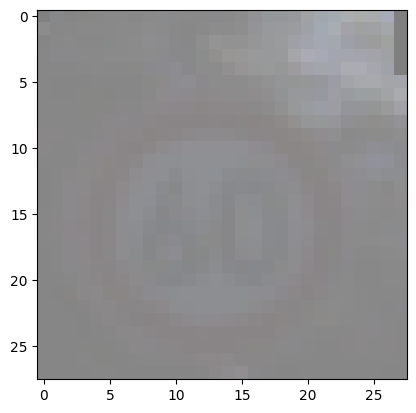

3 




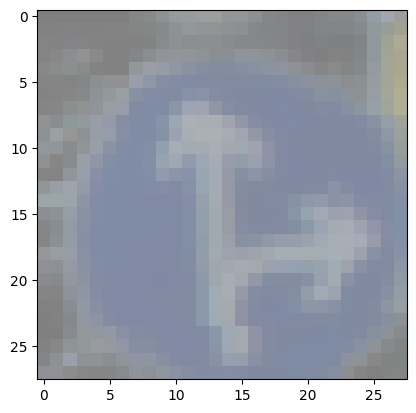

36 




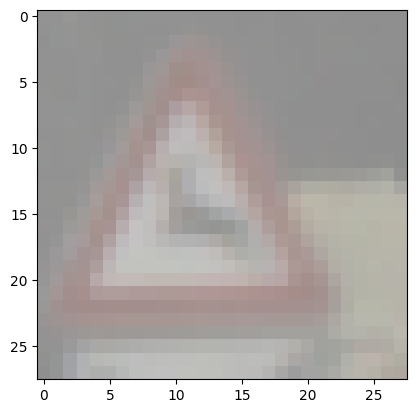

31 




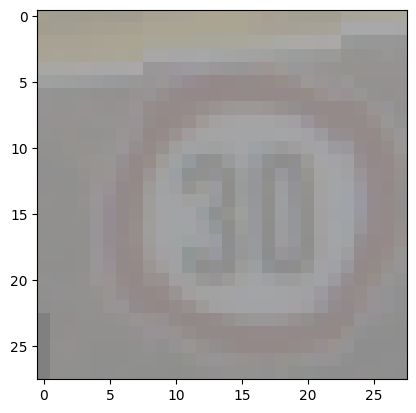

1 




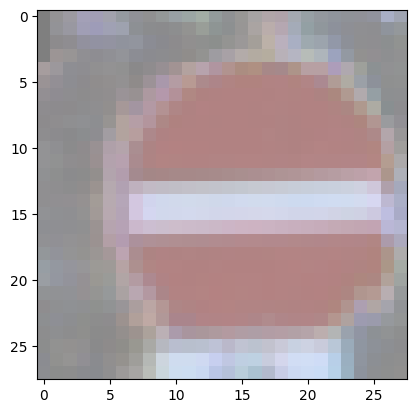

17 




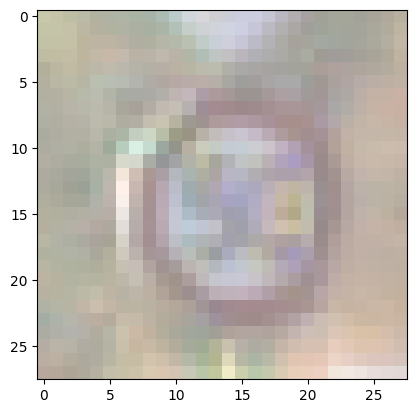

2 




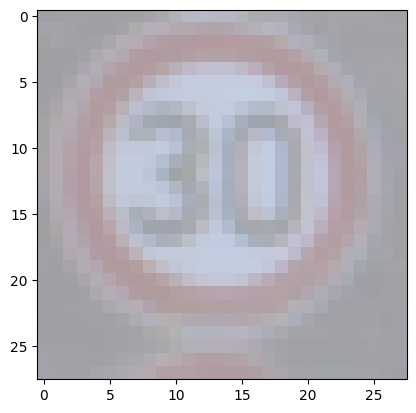

1 




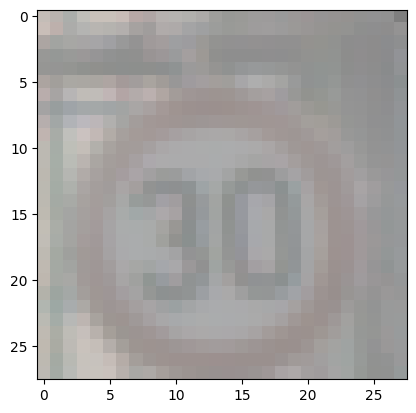

1 




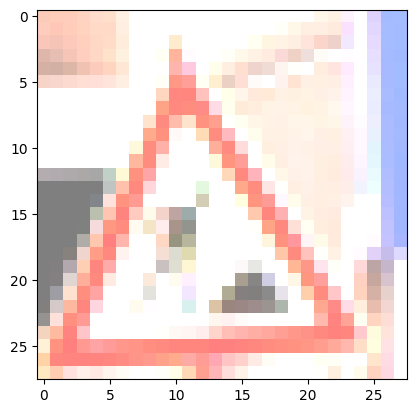

25 




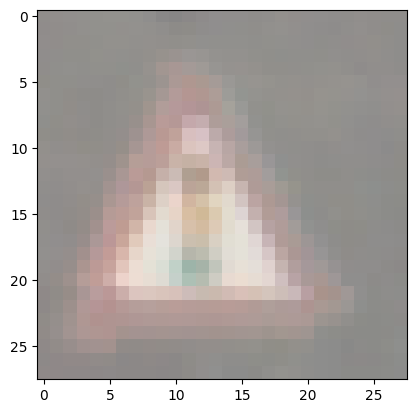

26 




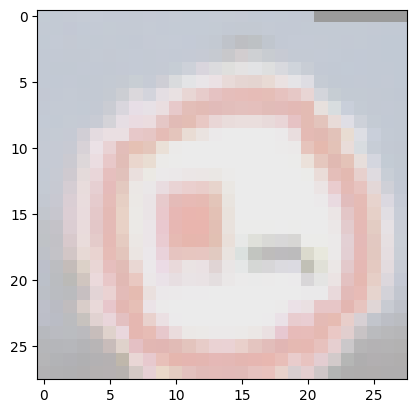

10 




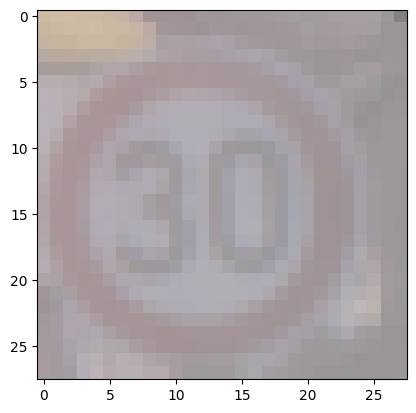

1 




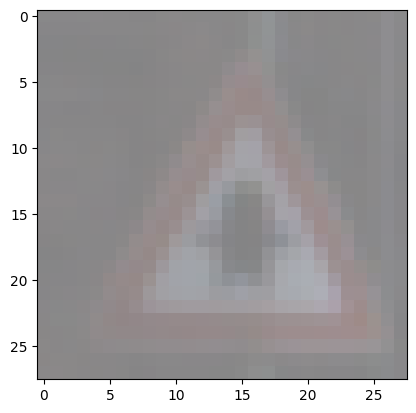

11 




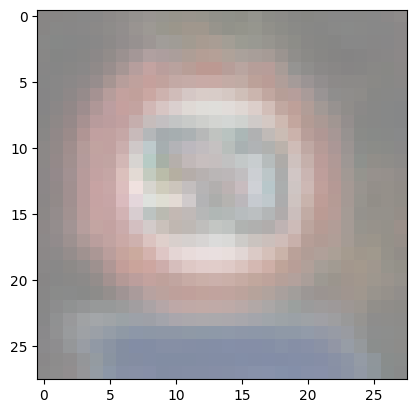

2 




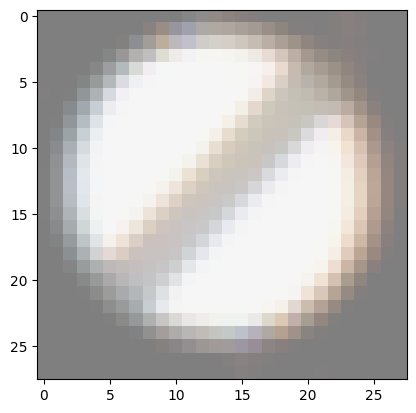

32 




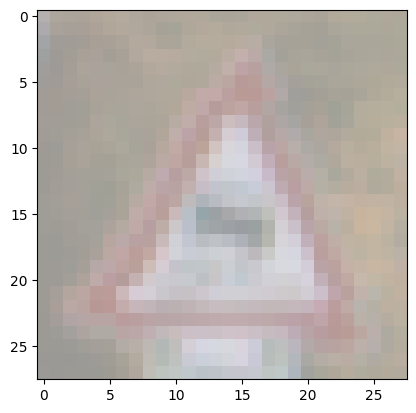

23 




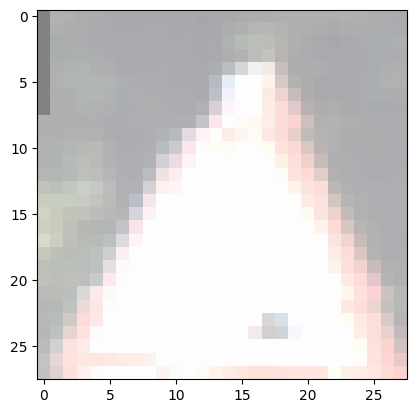

25 




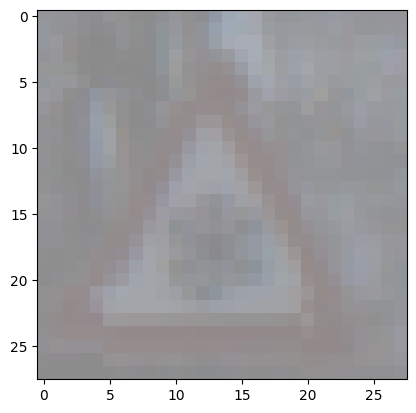

30 




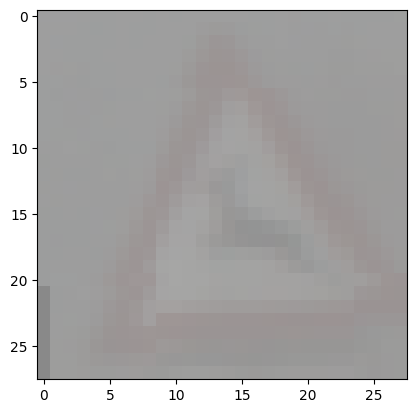

31 




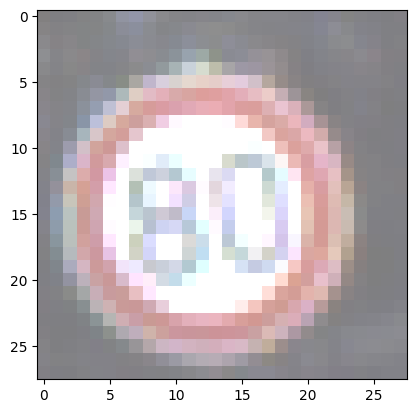

5 




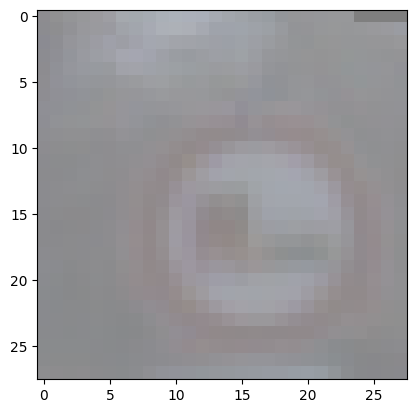

10 




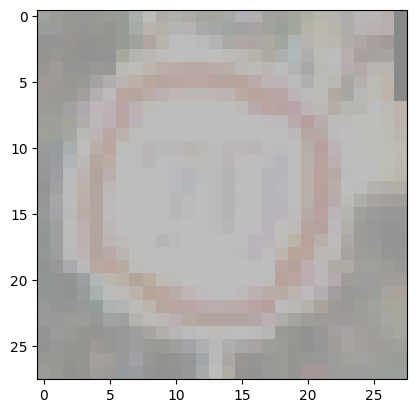

4 




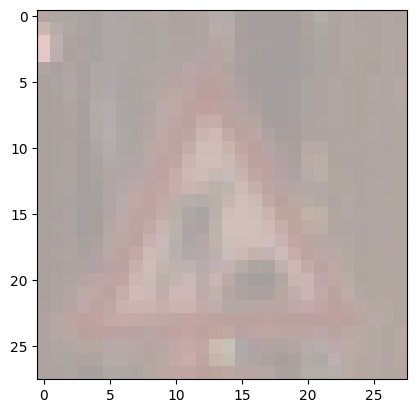

25 




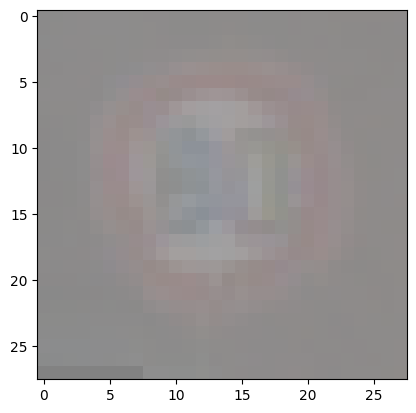

5 




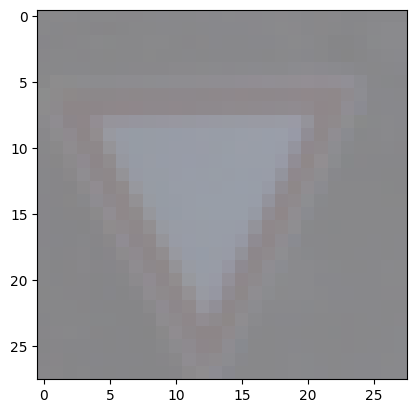

13 




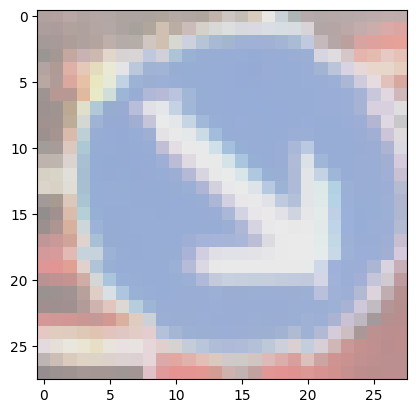

38 




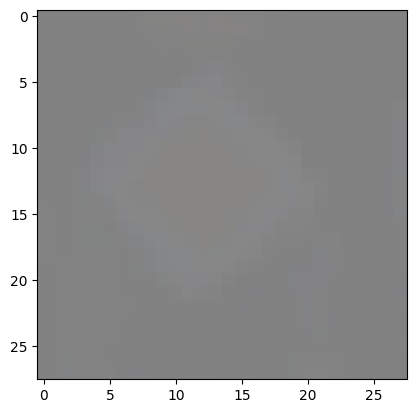

12 




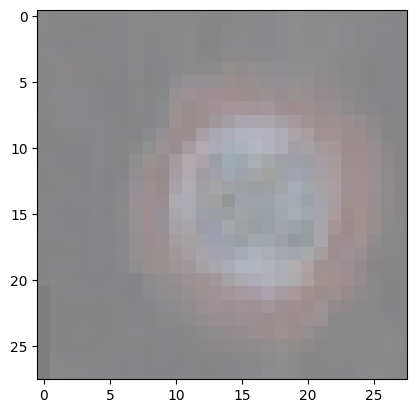

5 




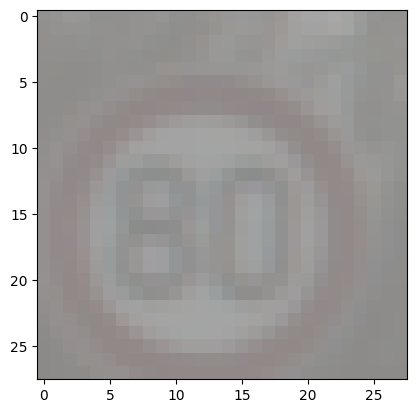

5 




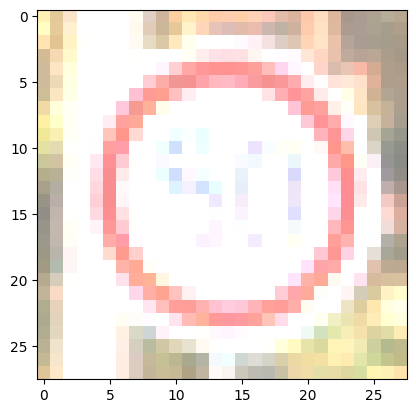

2 




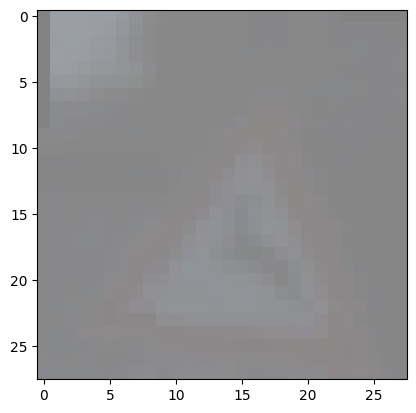

31 




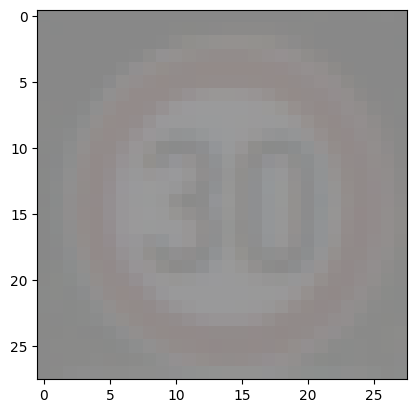

1 




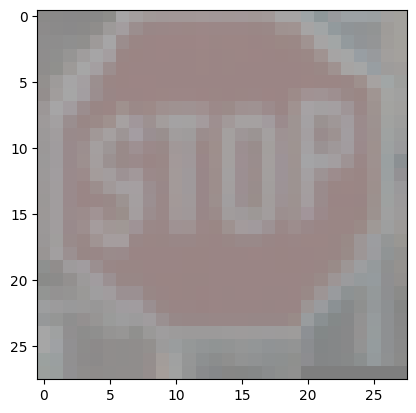

14 




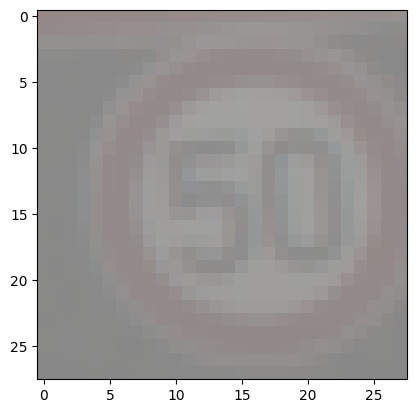

2 




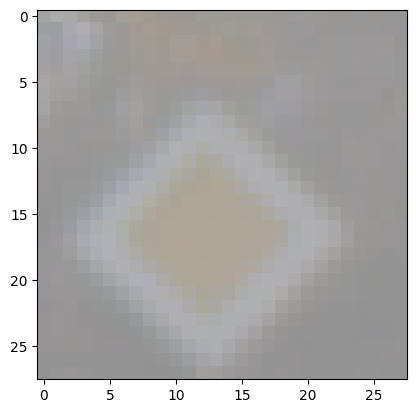

12 




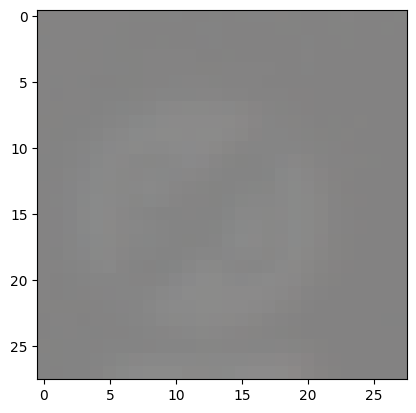

6 




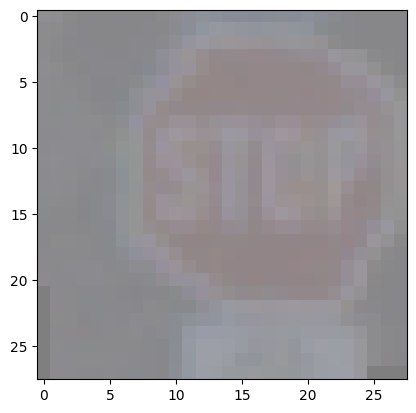

14 




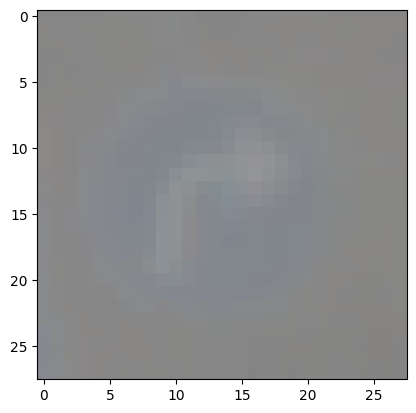

33 




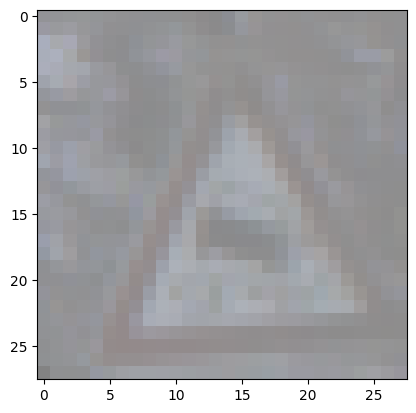

23 




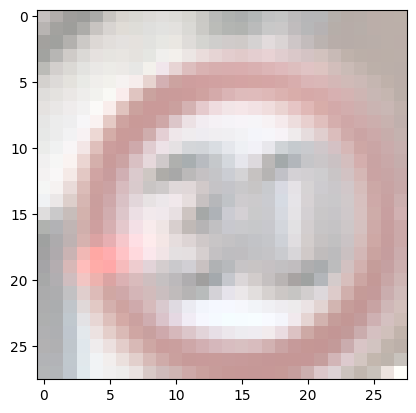

1 




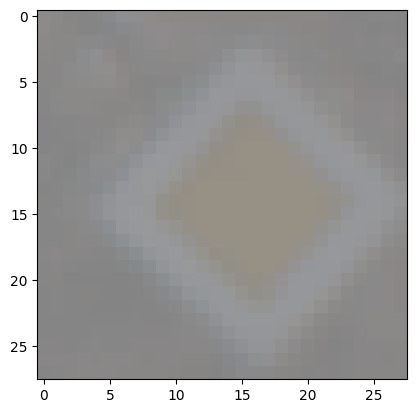

12 




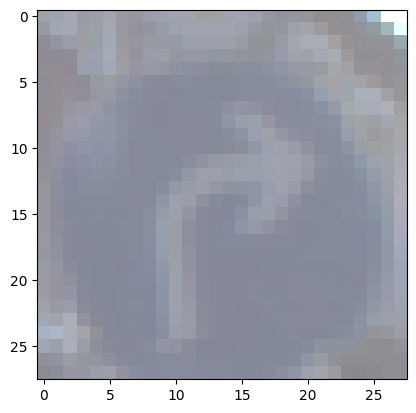

33 




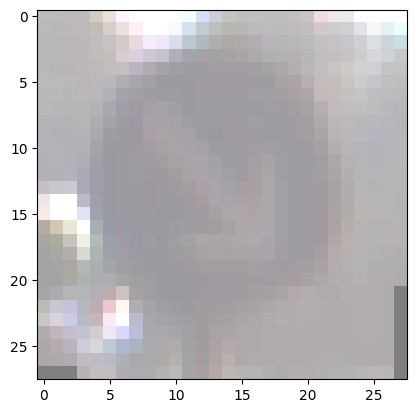

38 




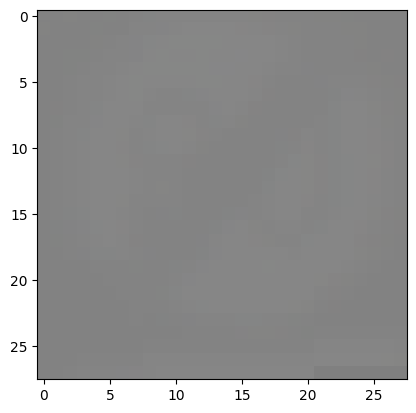

6 




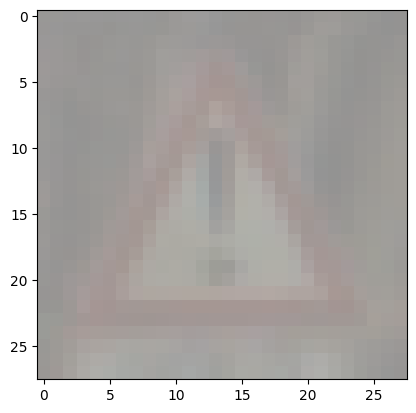

18 




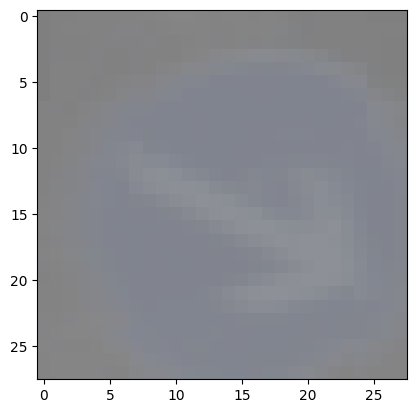

38 




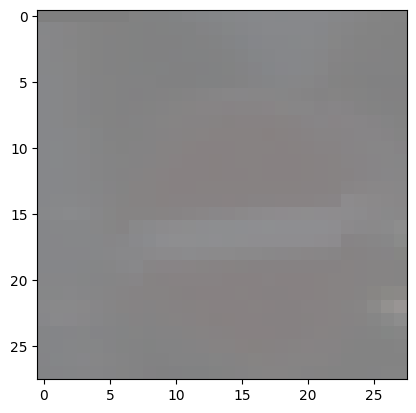

17 




In [16]:
for i in range(batch_size):
  imshow(images[i])
  print(labels[i].item(), "\n\n")


Define the neural network:

In [17]:
class Net(nn.Module):
    def __init__(self, img_size=28):
        super(Net, self).__init__()
        # convolutional layer creating 64 feature maps using 5×5 kernels
        self.conv1 = nn.Conv2d(3, 64, 5)       
        # 2 × 2 max-pooling layer 
        self.pool1 = nn.MaxPool2d(2)

        # convolutional layer creating 64 feature maps using 5×5 kernels
        self.conv2 = nn.Conv2d(64, 64, 5)
        # 2 × 2 max-pooling layer
        self.pool2 = nn.MaxPool2d(2)
        # linear fully-connected layer with 43 outputs
        self.fc = nn.Linear(1024, 43)


    def forward(self, x):        
        # convolutional layer creating 64 feature maps using 5×5 kernels
        x = self.conv1(x)
        x = F.elu(x)
        # 2 × 2 max-pooling layer
        x = self.pool1(x)

        # convolutional layer creating 64 feature maps using 5×5 kernels
        x = self.conv2(x)
        x = F.elu(x)
        # 2 × 2 max-pooling layer
        x = self.pool2(x)
        
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        # linear fully-connected layer with 43 outputs
        x = self.fc(x)
        
        return x



Instantiate the neural network and potentially move it to GPU:

In [18]:
net = Net()
if(gpu):
  net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=43, bias=True)
)


Define loss and optimization algorithm:

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

These lines can be used to continue training:

In [20]:
cont = False
if cont:
  net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [25]:
no_epochs = 200
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (gpu):
          inputs, labels = data[0].to(device), data[1].to(device)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.694
[1,   200] loss: 0.678
[1,   300] loss: 0.662
[2,   100] loss: 0.642
[2,   200] loss: 0.628
[2,   300] loss: 0.623
[3,   100] loss: 0.607
[3,   200] loss: 0.613
[3,   300] loss: 0.613
[4,   100] loss: 0.601
[4,   200] loss: 0.579
[4,   300] loss: 0.593
[5,   100] loss: 0.551
[5,   200] loss: 0.577
[5,   300] loss: 0.564
[6,   100] loss: 0.546
[6,   200] loss: 0.537
[6,   300] loss: 0.531
[7,   100] loss: 0.524
[7,   200] loss: 0.525
[7,   300] loss: 0.532
[8,   100] loss: 0.510
[8,   200] loss: 0.513
[8,   300] loss: 0.505
[9,   100] loss: 0.495
[9,   200] loss: 0.499
[9,   300] loss: 0.489
[10,   100] loss: 0.461
[10,   200] loss: 0.468
[10,   300] loss: 0.491
[11,   100] loss: 0.454
[11,   200] loss: 0.450
[11,   300] loss: 0.461
[12,   100] loss: 0.457
[12,   200] loss: 0.430
[12,   300] loss: 0.446
[13,   100] loss: 0.448
[13,   200] loss: 0.434
[13,   300] loss: 0.430
[14,   100] loss: 0.438
[14,   200] loss: 0.392
[14,   300] loss: 0.416
[15,   100] loss: 0

Evaluate on test set:

In [27]:
dataset_test = GTSRBTrafficSigns(train=False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
print("Number of test patterns:", dataset_test.__len__())

Using existing ./GTSRB/test
Number of test patterns: 12630


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
          images, labels = data[0].to(device), data[1].to(device)
        else:
          images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 94.64 %


Save network:

In [29]:
torch.save(net.state_dict(), 'traffic_simple')